In [43]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import pymp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functions.mandyocIO import read_datasets, _extract_interface

In [2]:
def calc_melt_dry(To,Po):

    P=np.asarray(Po)/1.0E6 # Pa -> MPa
    T=np.asarray(To)+273.15 #oC -> Kelvin

    Tsol = 1394 + 0.132899*P - 0.000005104*P**2
    cond = P>10000.0
    Tsol[cond] = 2212 + 0.030819*(P[cond] - 10000.0)

    Tliq = 2073 + 0.114*P

    X = P*0

    cond=(T>Tliq) #melt
    X[cond]=1.0

    cond=(T<Tliq)&(T>Tsol) #partial melt
    X[cond] = ((T[cond]-Tsol[cond])/(Tliq[cond]-Tsol[cond]))

    return(X)

def calc_melt_wet(To,Po):
    P=np.asarray(Po)/1.0E6 # Pa -> MPa
    T=np.asarray(To)+273.15 #oC -> Kelvin

    Tsol = 1240 + 49800/(P + 323)
    cond = P>2400.0
    Tsol[cond] = 1266 - 0.0118*P[cond] + 0.0000035*P[cond]**2

    Tliq = 2073 + 0.114*P

    X = P*0

    cond=(T>Tliq)
    X[cond]=1.0

    cond=(T<Tliq)&(T>Tsol)
    X[cond] = ((T[cond]-Tsol[cond])/(Tliq[cond]-Tsol[cond]))

    return(X)

In [56]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

dataset = ['pressure',
		   'temperature',
           'strain',
           'density']

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1 ])
# model_path = machine_path + scenario
dataset = read_datasets(model_path, dataset)

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")

if not os.path.isdir(output_path):
    os.makedirs(output_path)

dataset

<xarray.Dataset>
Dimensions:      (x: 1001, z: 301, time: 83)
Coordinates:
  * x            (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 -3e+05 -2.99e+05 -2.98e+05 ... -2e+03 -1e+03 0.0
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 38.11 38.61 39.11 39.61
    step         (time) int32 0 100 200 300 400 500 ... 7800 7900 8000 8100 8200
Data variables:
    pressure     (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_units:                    Pa

In [4]:
idx = 50#len(dataset.time)-1
melt_dry = calc_melt_dry(dataset.temperature[idx], dataset.pressure[idx])
melt_wet = calc_melt_dry(dataset.temperature[idx], dataset.pressure[idx])

print(f'Max Pressure: {float(np.max(dataset.pressure[idx])/1.0e9)} GPa') 

Max Pressure: 8.31937 GPa


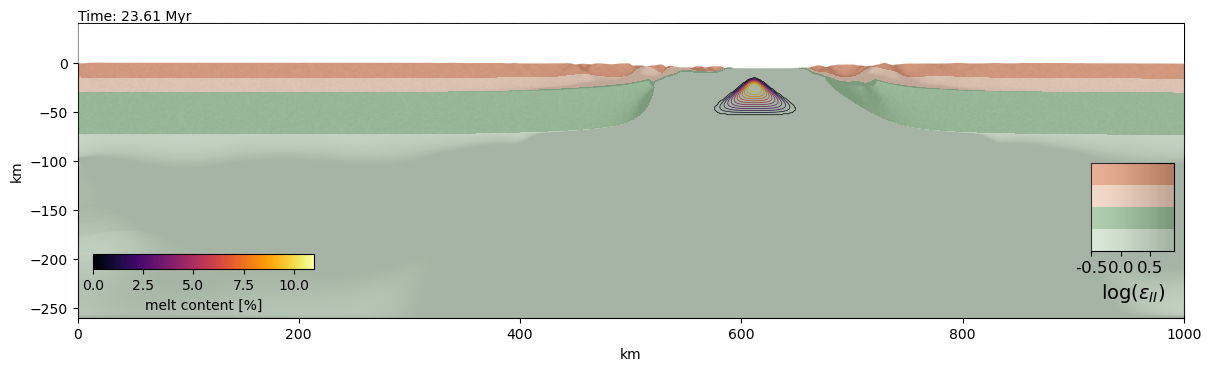

In [53]:
Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,12*(Lz/Lx)), constrained_layout=True)
# ax.set_aspect('equal')

cr = 255.
color_uc = (228. / cr, 156. / cr, 124. / cr)
color_lc = (240. / cr, 209. / cr, 188. / cr)
color_lit = (155. / cr, 194. / cr, 155. / cr)
color_ast = (207. / cr, 226. / cr, 205. / cr)

Rhoi = dataset.density[idx].T
interfaces=[2900, 3365]

##Extract layer topography
z = np.linspace(Lz/1000.0, 0, Nz)
Z = np.linspace(Lz/1000.0, 0, 8001) #zi
x = np.linspace(Lx/1000.0, 0, Nx)

xi = np.linspace(0, Lx/1000, Nx)
zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
xx, zz = np.meshgrid(xi, zi)
topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
condx = (xi >= 100) & (xi <= 600)
z_mean = np.mean(topo_interface[condx])
topo_interface -= np.abs(z_mean)
topo_interface = -1.0*topo_interface

ax.contourf(xx,
            zz,
            Rhoi,
            levels = [200., 2750, 2900, 3365, 3900],
            colors = [color_uc, color_lc, color_lit, color_ast])

im=ax.imshow(dataset.strain[idx].T,
                cmap = 'Greys',
                origin = 'lower',
                extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                zorder = 50,
                alpha = 0.2, vmin=-0.5,
                vmax = 0.7,
                aspect = 'auto')
#legend box
# b1 = [0.80, #horizontal position
#         0.22, #vertical position
#         0.15, #horizontal sift
#         0.20  #scale
#         ]
# # bv1 = plt.axes(b1)


bv1 = inset_axes(ax,
                width="20%",  # width: 30% of parent_bbox width
                height="30%",  # height: 5%
                bbox_to_anchor=(0.06,#horizontal position
                                -0.45,#vertical position
                                1,#
                                1),#
                bbox_transform=ax.transAxes,
                )
A = np.zeros((100, 10))

A[:25, :] = 2700
A[25:50, :] = 2800
A[50:75, :] = 3300
A[75:100, :] = 3400

A = A[::-1, :]

xA = np.linspace(-0.5, 0.9, 10)
yA = np.linspace(0, 1.5, 100)

xxA, yyA = np.meshgrid(xA, yA)
air_threshold = 200
bv1.contourf(
    xxA,
    yyA,
    A,
    levels=[air_threshold, 2750, 2900, 3365, 3900],
    colors=[color_uc, color_lc, color_lit, color_ast],
)

bv1.imshow(
    xxA[::-1, :],
    extent=[-0.5, 0.9, 0, 1.5],
    zorder=100,
    alpha=0.2,
    cmap=plt.get_cmap("Greys"),
    vmin=-0.5,
    vmax=0.9,
)

bv1.set_yticklabels([])
bv1.set_xlabel(r"log$(\varepsilon_{II})$", size=14)
bv1.tick_params(axis='x', which='major', labelsize=12)
bv1.set_xticks([-0.5, 0, 0.5])
bv1.set_yticks([])
bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

xlims = [0, float(dataset.isel(time=idx).lx) / 1.0e3]
ylims = [-float(dataset.isel(time=idx).lz) / 1.0e3 + 40, 40]
xaux = xx[0]
condaux = (xaux>xlims[0]) & (xaux<xlims[1])
xaux = xaux[condaux]
ax.fill_between(xaux, topo_interface[condaux], 39, color='white', alpha=1.0, zorder=51)


extent=(0, float(dataset.lx)/1.0e3,
        -float(dataset.lz)/1.0e3 + 40, 0 + 40)

# extent=(540, 560,
#         -30, -10)

levels = np.arange(0, np.max(melt_dry)*100, 1)
cs = ax.contour(melt_dry.T*100,
                levels,
                origin='lower',
                cmap='inferno',
                extent=extent,
                vmin=0, vmax=np.max(melt_dry)*100,
                linewidths=0.5,
                # linewidths=30,
                zorder=30)

axins1 = inset_axes(ax,
                    width="20%",  # width: 30% of parent_bbox width
                    height="5%",  # height: 5%
                    bbox_to_anchor=(-0.78,
                                    -0.76,
                                    1,
                                    1),
                    bbox_transform=ax.transAxes,
                    )

norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])

fig.colorbar(sm,
             cax=axins1,
             label='melt content [%]',
             orientation='horizontal',
             fraction=0.008,
             pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)

ax.set_xlabel("km")
ax.set_ylabel("km")
# ax.set_xticks(np.arange(0, 1001, 50))
model_name = os.path.split(model_path)[1]
                

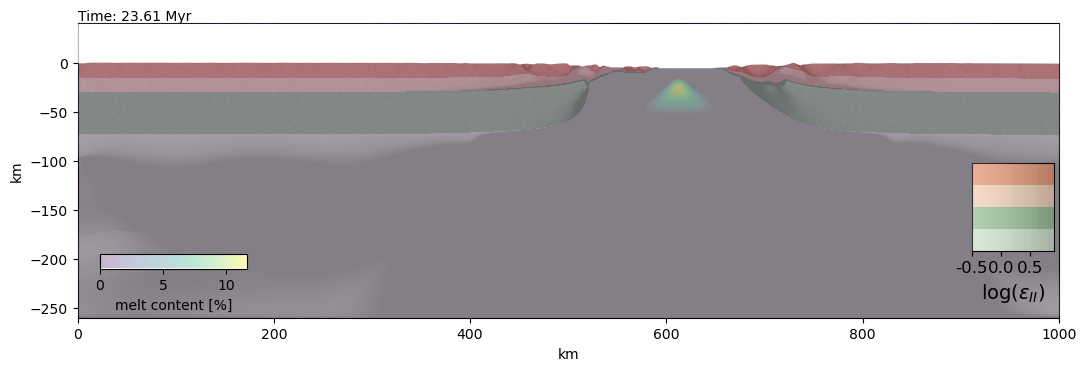

In [34]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,12*(Lz/Lx)), constrained_layout=True)

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

cr = 255.
color_uc = (228. / cr, 156. / cr, 124. / cr)
color_lc = (240. / cr, 209. / cr, 188. / cr)
color_lit = (155. / cr, 194. / cr, 155. / cr)
color_ast = (207. / cr, 226. / cr, 205. / cr)

Rhoi = dataset.density[idx].T
interfaces=[2900, 3365]

##Extract layer topography
z = np.linspace(Lz/1000.0, 0, Nz)
Z = np.linspace(Lz/1000.0, 0, 8001) #zi
x = np.linspace(Lx/1000.0, 0, Nx)

xi = np.linspace(0, Lx/1000, Nx)
zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
xx, zz = np.meshgrid(xi, zi)
topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
condx = (xi >= 100) & (xi <= 600)
z_mean = np.mean(topo_interface[condx])
topo_interface -= np.abs(z_mean)
topo_interface = -1.0*topo_interface

ax.contourf(xx,
            zz,
            Rhoi,
            levels = [200., 2750, 2900, 3365, 3900],
            colors = [color_uc, color_lc, color_lit, color_ast])

im=ax.imshow(dataset.strain[idx].T,
                cmap = 'Greys',
                origin = 'lower',
                extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                zorder = 50,
                alpha = 0.2,
                vmin=-0.5,
                vmax = 0.7,
                aspect = 'auto')
#legend box
bv1 = inset_axes(ax,
                width="20%",  # width: 30% of parent_bbox width
                height="30%",  # height: 5%
                bbox_to_anchor=(0.06,#horizontal position
                                -0.45,#vertical position
                                1,#
                                1),#
                bbox_transform=ax.transAxes,
                )
A = np.zeros((100, 10))

A[:25, :] = 2700
A[25:50, :] = 2800
A[50:75, :] = 3300
A[75:100, :] = 3400

A = A[::-1, :]

xA = np.linspace(-0.5, 0.9, 10)
yA = np.linspace(0, 1.5, 100)

xxA, yyA = np.meshgrid(xA, yA)
air_threshold = 200
bv1.contourf(
    xxA,
    yyA,
    A,
    levels=[air_threshold, 2750, 2900, 3365, 3900],
    colors=[color_uc, color_lc, color_lit, color_ast],
)

bv1.imshow(
    xxA[::-1, :],
    extent=[-0.5, 0.9, 0, 1.5],
    zorder=100,
    alpha=0.2,
    cmap=plt.get_cmap("Greys"),
    vmin=-0.5,
    vmax=0.9,
)

bv1.set_yticklabels([])
bv1.set_xlabel(r"log$(\varepsilon_{II})$", size=14)
bv1.tick_params(axis='x', which='major', labelsize=12)
bv1.set_xticks([-0.5, 0, 0.5])
bv1.set_yticks([])
bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

xlims = [0, float(dataset.isel(time=idx).lx) / 1.0e3]
ylims = [-float(dataset.isel(time=idx).lz) / 1.0e3 + 40, 40]
xaux = xx[0]
condaux = (xaux>xlims[0]) & (xaux<xlims[1])
xaux = xaux[condaux]
ax.fill_between(xaux, topo_interface[condaux], 39, color='white', alpha=1.0, zorder=51)


extent=(0,
        float(dataset.lx)/1.0e3,
        -float(dataset.lz)/1.0e3 + 40,
        0 + 40)

# extent=(540, 560,
#         -30, -10)

# melt_dry[melt_dry==0] = np.nan

im = ax.imshow(melt_dry.T*100.,
               origin='lower',
               cmap='viridis',
               extent=extent,
               vmin=0, vmax=np.max(melt_dry)*100,
               alpha=0.3,
               zorder=45)

axins1 = inset_axes(ax,
                    width="15%",  # width: 30% of parent_bbox width
                    height="5%",  # height: 5%
                    bbox_to_anchor=(-0.82,
                                    -0.76,
                                    1,
                                    1),
                    bbox_transform=ax.transAxes,
                    )

fig.colorbar(im,
             cax=axins1,
             label='melt content [%]',
             orientation='horizontal',
             fraction=0.008,
             pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)

ax.set_xlabel("km")
ax.set_ylabel("km")
plt.axis('equal')
model_name = os.path.split(model_path)[1]
                

In [ ]:
np.shape(Rhoi)

In [ ]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
extent=(0, float(dataset.lx)/1.0e3,
        -float(dataset.lz)/1.0e3 + 40, 0 + 40)

# extent=(540, 560,
#         -30, -10)

levels = np.arange(0, np.max(melt_dry)*100, 1)
cs = ax.contour(melt_dry.T*100, levels,
                origin='lower',
                cmap='inferno',
                extent=extent,
                vmin=0, vmax=np.max(melt_dry)*100,
                linewidths=0.5)
# ax.clabel(cs, cs.levels, inline=False)

fig.colorbar(cs, label='melt content [%]',
	orientation='vertical',
    fraction=0.015, pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)

ax.set_xlabel("km")
ax.set_ylabel("km")
model_name = os.path.split(model_path)[1]
# fig_name = f"{output_path}/{model_name}_Melt_Fraction_{str(int(dataset.step[idx])).zfill(6)}.png"
# plt.savefig(fig_name, dpi=400)

In [ ]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
extent=(0, float(dataset.lx)/1.0e3,
        -float(dataset.lz)/1.0e3 + 40, 0 + 40)

levels = np.arange(0, np.max(melt_dry)*100, 1)

im = ax.imshow(melt_dry.T*100., origin='lower', cmap='viridis', extent=extent, vmin=0, vmax=np.max(melt_dry)*100)
fig.colorbar(im, label='melt content [%]',
	orientation='vertical',
    fraction=0.015, pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)
ax.set_xlabel("km")
ax.set_ylabel("km")

In [ ]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(8,6), constrained_layout=True)
im = ax.contourf(np.asarray(dataset.temperature[idx]).T, np.asarray(dataset.pressure[idx]/1.0E9).T, melt_wet.T*100)
fig.colorbar(im, label='melt content [%]',
	orientation='vertical',
    fraction=0.015, pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)
ax.set_xlabel("Temperature ($^\circ$C)")
ax.set_ylabel("Pressure (GPa)")

In [ ]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(8,6), constrained_layout=True)
im = ax.contour(np.asarray(dataset.temperature[idx]).T, np.asarray(dataset.pressure[idx]/1.0E9).T, melt_wet.T*100)
fig.colorbar(im, label='melt content [%]',
	orientation='vertical',
    fraction=0.015, pad=0.02)

ax.text(0, 1.01, f'Time: {np.round(float(dataset.time[idx]), 2)} Myr', transform=ax.transAxes)
ax.set_xlabel("Temperature ($^\circ$C)")
ax.set_ylabel("Pressure (GPa)")

In [ ]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

# start = int(t0)
# end = int(dataset.time.size - 1)
# step = 1#5

start = 0
end = 10
step = 1

with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):